In [1]:
### 🛑 Import des bibliothèques
import numpy as np
pi = np.pi
import matplotlib.pyplot as plt
import scipy as sp
from scipy import fft, signal
import time

<span style="font-size: x-large;">⚠️</span> Prenez le temps de lire l'intégralité du notebook. Les longues parties de texte sont vraiment nécessaires pour acquérir le niveau de compréhension minimal pour pouvoir exploiter en pratique la TFD, et ne pas tomber dans ses nombreux écueils.

# Du monde continu au monde discret pour la transformée de Fourier

## Transformée de Fourier continue

<br>
Dans le cours, on opère avec des signaux continus $x:\mathbb{R} \rightarrow \mathbb{R}$ (ou $\mathbb{C}$), $t \mapsto x(t)$ dont la transformée de Fourier $X = \mathcal{F}(x)$ est également continue :


$$\begin{align}
X :\mathbb{R} &\rightarrow \mathbb{C}\\
\nu &\mapsto X(\nu) = \displaystyle \int_{\mathbb{R}} x(t) e^{-i 2 \pi \nu t} dt \quad (1)
\end{align}$$

Une condition suffisante à l'existence de cette transformée de Fourier est que le signal $x$ soit intégrable : $x \in \mathcal{L}^1(\mathbb{R})$.
Si, de plus, $X \in \mathcal{L}^1(\mathbb{R})$, alors la transformée de Fourier est inversible : on peut reconstruire $x$ à partir de $X$ via la formule de la transformée de Fourier inverse : 

$$ x(t) = \int_\mathbb{R} X(\nu) e^{i 2 \pi \nu t} d\nu \quad (2)$$ 

## Discrétisation de la transformée de Fourier

<br>
Bien entenu, lorsqu'on manipule réellement un signal sur un ordinateur (ou n'importe quel support à mémoire finie), celui-ci est discret et fini. Le signal $x$ est un vecteur de $N$ points : $x = \big[x[0],\dots,x[N-1]\big]$. Il en va de même pour sa transformée de Fourier, qui doit également être finie et discrète : on parle alors de transformée de Fourier discrète (quelle surprise !), ou TFD (DFT pour <i>Discrete Fourier Transform</i> en anglais).

Qu'est ce que ça change en pratique ? Pas mal de choses, malheureusement. Et sans forcément aller très loin dans les détails, il faut quand même prendre le temps d'expliciter un certain nombre de points nécessaires à une bonne (ou en tout cas, un début de) compréhension de la TFD.

Par défaut, la TFD $X$ d'un signal $x$ se calcule également sur $N$ points (bien qu'il soit aussi possible de la calculer sur $M > N$ points, comme on le verra par la suite). Ainsi, $X$ est également un vecteur de longueur $N$ : $X = \big[X[0],\dots,X[N-1]\big]$, dont chaque composante $X[k]$ s'obtient par la formule de la TFD :
$$X[k] = \displaystyle \sum_{n=0}^{N-1} x[n] e^{-i 2 \pi \frac{nk}{N}} \quad k = 0,\dots,N-1 \quad (3)$$

On peut se convaincre sans trop de peine que $(3)$ est bien une version discrétisée de $(1)$ pour un signal de longueur finie.

La transformée de Fourier discrète inverse (IDFT pour <i>Inverse Discrete Fourier Transform</i> en anglais), permet de retrouver $x$ à partir de $X$ grâce à la formule :

$$x[n] = \displaystyle \frac{1}{N}\sum_{k=0}^{N-1} X[k] e^{i 2 \pi \frac{nk}{N}} \quad n = 0,\dots,N-1 \quad (4),$$ 

qui ressemble aussi pas mal à l'écriture du théorème de Dirichlet (modulo le fait que le signal $x$ est discret et fini et qu'il ne contient que des harmoniques jusqu'à l'ordre $N-1$)

Et c'est tout ?

Non, bien sûr que non, ça serait trop simple sinon... Faisons donc un petit tour d'horizon des choses à garder en tête lorsque l'on manipule une TFD.

## Manipuler des signaux discrets en pratique

En numpy, un signal $x$ de longueur $N$ n'est qu'un tableau de données (un `np.array`) contenant $N$ valeurs, dont les indices sont donc numérotés de $0$ (pour la première valeur de $x$) à $N-1$ (pour la dernière valeur de $x$).

In [2]:
# 🛑 Définition d'un tableau de taille 10 avec des valeurs aléatoires (dans [0,5[)
N = 10
x = np.random.randint(5,size=N)
print("x:",x)
print("x est de type",type(x))
print("Nombre d'éléments:",x.size)
print("Première valeur de x : x[0]=",x[0])
print("Dernière valeur de x : x[N-1]=",x[N-1])

x: [2 0 1 1 4 0 0 0 0 2]
x est de type <class 'numpy.ndarray'>
Nombre d'éléments: 10
Première valeur de x : x[0]= 2
Dernière valeur de x : x[N-1]= 2


À noter qu'il n'y a pas besoin de connaître explicitement la taille $N$ du signal $x$ pour accéder à sa dernière valeur : `x[N-1]` s'accède plus simplement par `x[-1]` (et l'avant dernière valeur `x[N-2]` s'accède par `x[-2]`, etc).

In [3]:
# 🛑 Test de l'indexing inversé
print(x[N-1]==x[-1])

True


Une manière plus conventionnelle (en tout cas, quand on fait du traitement du signal) d'afficher un signal $x$ est de tracer sa représentation temporelle avec `plt.plot(x)` (+ quelques options supplémentaires qu'on finit par connaître à force de jouer avec `matplotlib` pour que le graphe soit bien propre)

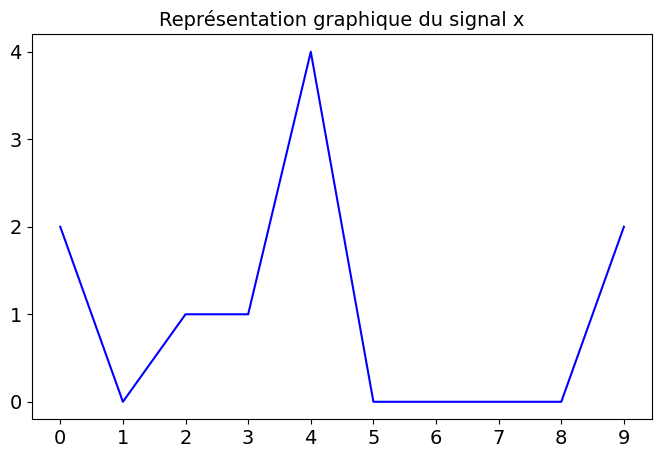

In [4]:
# 🛑 Tracé d'un signal
plt.figure(figsize=(8,5))
plt.plot(x,'b')
plt.title("Représentation graphique du signal x",fontsize=14)
plt.xticks(ticks=np.arange(0,N),fontsize=14)
plt.yticks(ticks=np.arange(0,x.max()+1),fontsize=14)
plt.show()

### Discrétisation de l'axe des temps

Sans grande surprise, les indices des différentes cases d'un `np.array` de taille $N$ sont des entiers entre 0 et $N-1$, et ne correspondent pas forcément à l'échelle de temps sur laquelle le signal est défini. En pratique, on a plutôt envie de faire correspondre à chaque indice $n = 0,\dots,N-1$ une certaine valeur de temps $t_n$, de manière à ce que que $x[n]$ soit à comprendre au sens $x[t_n]$ : c'est le $(n+1)^\text{ème}$ échantillon du signal discret $x$, et non la valeur de $x$ en $t=n$.

Pour cela, il faut donc définir $N$ points de mesure $t_n, n=0,\dots,N-1$ sur l'axe des "temps" (ou peu importe ce que représente la variable $t$), de manière à ce que chaque indice $n$ du signal puisse être relié à sa valeur de temps correspondant $t_n$ : $x[n]$ s'interprète donc comme la valeur qui a été échantillonnée à partir du signal $x$ au temps $t_n$.

Bien que les points de mesure $t_n$ puissent être définis un peu comme on veut, on les prend en général régulièrement espacés dans le temps.
En pratique, il y a deux manières de procéder pour générer un vecteur de temps discret :
* [`np.arange`](https://numpy.org/doc/stable/reference/generated/numpy.arange.html) : `t = np.arange(tmin,tmax,Te)` génère un vecteur de valeurs débutant à `tmin` (inclus), jusqu'à `tmax` (exclu) avec un pas de temps `Te` entre chaque valeur. Dans ce cas, on appelle $T_e$ la <b>période d'échantillonnage</b> (comme on le verra plus tard lors du cours traitant de la conversion analogique-numérique), et $f_e = \frac{1}{T_e}$ est la <b>fréquence d'échantillonnage</b> (c'est le nombre de points par unité de temps).
* [`np.linspace`](https://numpy.org/doc/stable/reference/generated/numpy.linspace.html) : `t = np.linspace(tmin,tmax,N)` génère un vecteur de `N` valeurs régulièrement espacées entre `tmin` (inclus) et `tmax` (inclus aussi).

⚠️ `np.arange` et `np.linspace` ont beau se ressembler, ils s'utilisent dans deux contextes différents : le premier est à préférer lorsqu'on contrôle la période d'échantillonnage et l'intervalle de temps (auquel cas, le nombre d'échantillons à calculer est déterminé automatiquement), alors que le deuxième est à privilégier lorsque l'on veut contrôler le nombre d'échantillons à générer dans un intervalle de temps donné (auquel cas, la période d'échantillonnage est déterminée automatiquement). Le fait que `np.arange` exclut la borne supérieur de l'intervalle de temps alors que `np.linspace` l'inclut complique un peu les choses et le passage de l'un à l'autre...

En reprenant le signal $x$ précédent, si on veut étalonner ses 10 valeurs sur une échelle de temps entre $0$ et $1$, on pourra donc écrire :
* soit `np.arange(0,1,1/x.size)` -> utilisation d'un pas de temps d'$\frac{1}{10}$ entre 0 (inclus) et 1 (exclu).
* soit `np.linspace(0,1,x.size)` -> génération de 10 valeurs régulièrement espacées entre 0 (inclus) et 1 (inclus).

In [5]:
# 🛑 Définition d'un vecteur de temps discret
t_arange = np.arange(0,1,1/x.size)
print("Vecteur de temps généré par np.arange :",t_arange)
t_linspace = np.linspace(0,1,x.size)
print("Vecteur de temps généré par np.linspace :",t_linspace)

Vecteur de temps généré par np.arange : [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
Vecteur de temps généré par np.linspace : [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]


Dans les deux cas, on pourra mettre l'axe des abscisses à l'échelle voulue en passant également le vecteur de temps discret à `plt.plot` avec `plt.plot(t,x)`

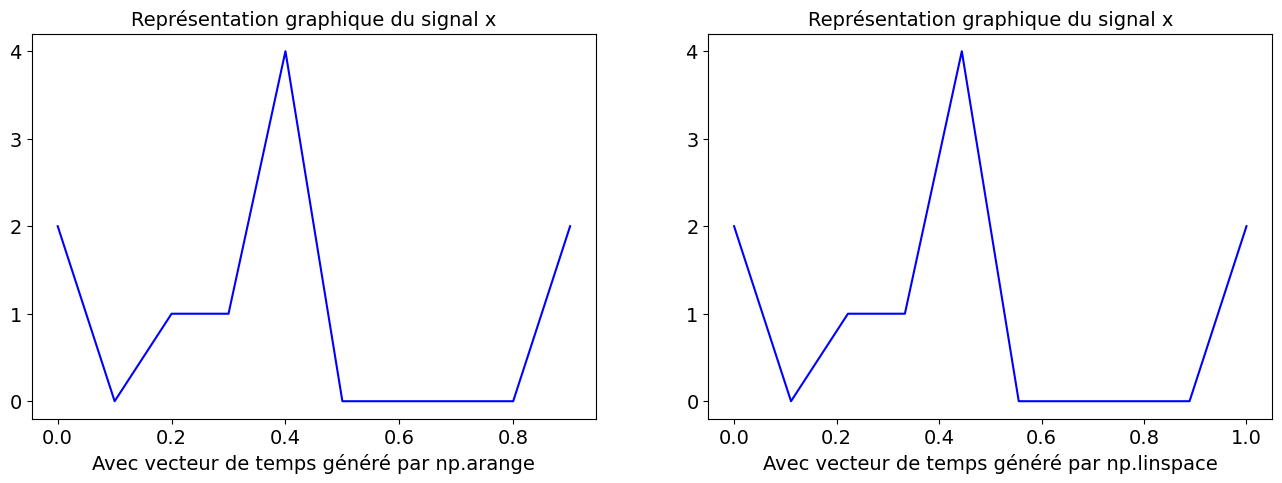

In [6]:
# 🛑 Tracé du signal
plt.figure(figsize=(16,5))
plt.subplot(121)
plt.plot(t_arange,x,'b')
plt.title("Représentation graphique du signal x",fontsize=14)
plt.xlabel("Avec vecteur de temps généré par np.arange",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(ticks=np.arange(0,x.max()+1),fontsize=14)
plt.subplot(122)
plt.plot(t_linspace,x,'b')
plt.title("Représentation graphique du signal x",fontsize=14)
plt.xlabel("Avec vecteur de temps généré par np.linspace",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(ticks=np.arange(0,x.max()+1),fontsize=14)
plt.show()

Le fait que `np.arange` exclut la borne max de l'intervalle lors de sa création alors que `np.linspace` l'inclut est bien visible sur la figure précédente : le graphe de gauche (avec `np.arange`) "s'arrête" avant $t=1$ (puisque la dernière valeur de `t_arange` est $0.9$) alors que le graphe de droite (avec `np.linspace`) "s'arrête" bien à $t=1$ (qui est la dernière valeur de `t_linspace`).

C'est la première difficulté à laquelle on se frotte lorsqu'on cherche à représenter graphiquement l'évolution temporelle d'un signal numérique, à savoir l'importance de la bonne définition d'un vecteur de temps. 

### 🛠️ 🚧 👷  À vous de jouer !

Prenez le temps de bien comprendre les différences de fonctionnement de `np.arange` et `np.linspace`, car vous allez vous en servir régulièrement dans les TPs d'ITSI à partir de maintenant.

En particulier, essayez de faire concorder les vecteurs de temps discrets générés par ces deux fonctions :
* comment faut-il modifier les arguments de `np.linspace` pour obtenir la même sortie que `np.arange(0,1,0.1)` ?
* comment faut-il modifier les arguments de `np.arange` pour obtenir la même sortie que `np.linspace(0,1,10)` ?

In [7]:
# Concordance de np.linspace sur np.arange
t_arange = np.arange(0,1,0.1)
print("t_arange :",t_arange)
t_newlinspace = np.linspace(0,0.9,10) # FIXME
print("t_newlinspace :",t_newlinspace)
print(np.all(t_newlinspace == t_arange))

t_arange : [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
t_newlinspace : [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
True


In [8]:
# Concordance de np.arange sur np.linspace
t_linspace = np.linspace(0,1,10)
print("t_linspace :",t_linspace)
t_newarange = np.arange(0,1+(1/9)/2,1/9) # FIXME
print("t_newarange :",t_newarange)
print(np.all(t_newarange == t_linspace))

t_linspace : [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
t_newarange : [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
True


On va maintenant pouvoir rentrer dans le vif du sujet ! Pour cela, on va commencer par générer un vecteur de temps entre $t=-5$ (secondes) et $t=5$ (secondes), en controlant la période d'échantillonnage $T_e = 0.01$ (donc le pas de temps entre deux valeurs successives). Si vous avez compris la question précédente, vous ne serez donc pas surpris de retrouver `np.arange` dans la cellule suivante.

In [9]:
# 🛑 Définition d'un vecteur de temps discret
tmin = -5
tmax = 5
Te = 0.01 # Période d'échantillonnage (pas de temps)
fe = 1/Te # Fréquence d'échantillonnage
t = np.arange(tmin,tmax,Te) # t de tmin (inclus) à tmax (exclu) avec pas de temps Te
N = t.size # Nombre de points générés

Maintenant qu'on a défini l'échelle de temps $t$, définissons un signal cosinus $\displaystyle x(t) = A \cos \left(\frac{2\pi}{T} t\right)$, de période propre $T$ (donc de fréquence propre $F = \frac{1}{T}$).

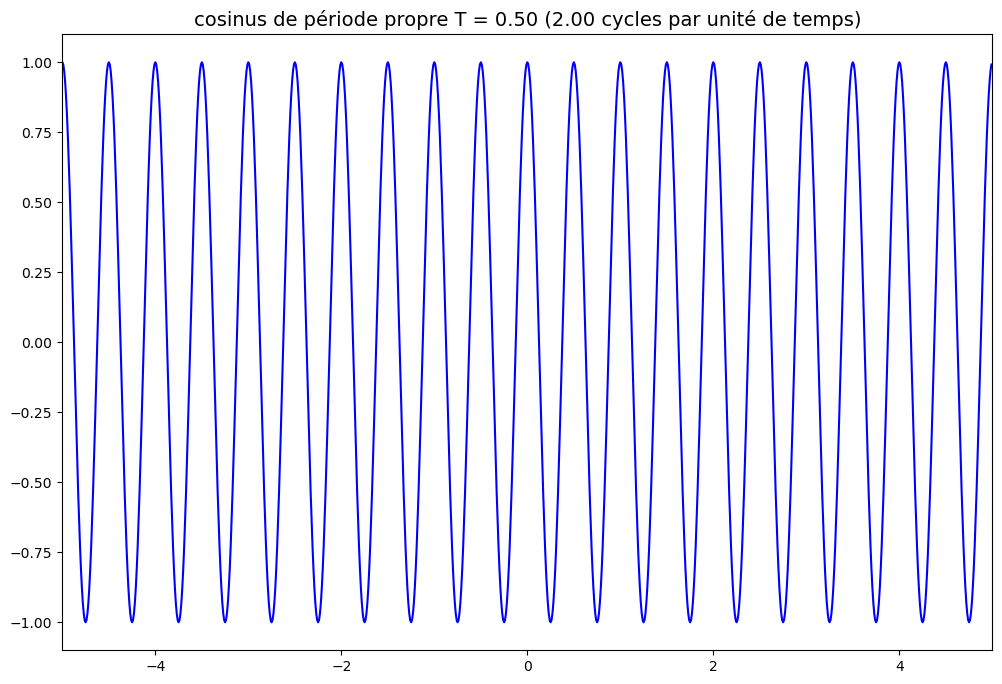

In [10]:
# Définition d'un signal cosinus
A = 1 # Amplitude
T = 0.5 # Période propre
F = 1/T # Fréquence propre
x = A*np.cos(2*pi*t/T)

plt.figure(figsize=(12,8))
plt.title('cosinus de période propre T = %1.2f (%1.2f cycles par unité de temps)'%(T,F),fontsize=14)
plt.plot(t,x,'b')
plt.xlim(tmin,tmax)
plt.show()

### 🛠️ 🚧 👷  À vous de jouer !

Jouez avec la cellule précédente en faisant varier $A$ et $T$, en prenant garde à définir $T$ (donc la durée d'une période) pour afficher <b>un nombre entier de périodes</b> sur toute la durée du signal pour le moment (par exemple, $T = 0.1$, $T=1$, $T=2.5$, etc, mais pas $T=3$, $T = 2\pi$, etc...). D'après le cours, quelle devrait être la transformée de Fourier des différents cosinus que vous définissez ? 

D'après le cours, la transformée de Fourier d'un signal de la forme $\displaystyle x(t) = A \cos \left(\frac{2\pi}{T} t\right)$ est ❓❓❓ ($\leftarrow$ une réponse avec des mots suffit).

### 🛠️ 🚧 👷  À vous de jouer !

Calculez maintenant la TFD $X$ du signal précédent grâce à [`sp.fft.fft`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.fft.html) (bien sûr, allez voir la doc au préalable...) et affichez le spectre (c'est-à-dire le module $ \vert X \vert$ de $X$ grâce à [`np.abs`](https://numpy.org/doc/stable/reference/generated/numpy.absolute.html)). Est-ce conforme à ce que vous attendiez ?

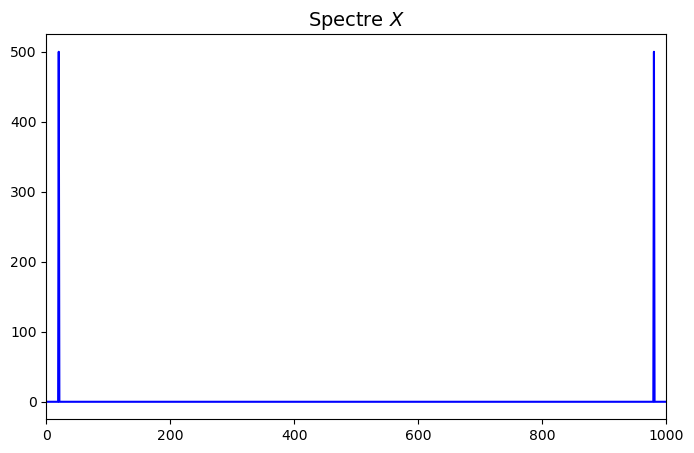

In [12]:
X = sp.fft.fft(x) # FIXME
plt.figure(figsize=(8,5))
plt.title(r'Spectre $X$',fontsize=14)
plt.plot(np.abs(X),'b') # FIXME
plt.xlim(0,N)
plt.show()

Le spectre qu'on obtient [est conforme / n'est pas conforme] à la théorie parce que ❓❓❓

### Discrétisation de l'axe des fréquences

Tout comme l'axe des temps a été discrétisé en $N$ points de mesure dans la partie précédente, il faut en faire de même avec l'axe des fréquences pour afficher la transformée de Fourier. <br>
Ainsi, $X[k]$ est à comprendre au sens $X[\nu_k]$. Les $\{ \nu_k, k=0,\dots,N-1 \}$ s'appellent les <b>fréquences discrètes</b>, et il y a plusieurs choses à savoir à leur propos :

1) ces fréquences discrètes $\nu_k$ sont forcément comprises entre $\displaystyle -\frac{f_e}{2}$ et $\displaystyle \frac{f_e}{2}$ (on rappelle ici que $\displaystyle f_e = \frac{1}{T_e}$ avec $T_e$ le pas de temps du vecteur temps). Cette propriété est à admettre pour le moment, puisque c'est une conséquence du théorème de Shannon, qui sera vu plus tard dans le cours. 

2) Puisque la TFD se calcule par défaut sur $N$ points, il y a donc $N$ fréquences discrètes couvrant un intervalle $\displaystyle [-\frac{f_e}{2},\frac{fe}{2}]$ (donc de largeur $f_e$). Ainsi, le pas d'échantillonnage en fréquence est $\displaystyle \frac{fe}{N}$. 

3) L'échantillonnage en fréquence varie selon que $N$ est pair ou impair :

$$\begin{align}
\nu &= \frac{f_e}{N} [ -\frac{N}{2},-\frac{N}{2}+1,\dots,\frac{N}{2}-1] = [-\frac{fe}{2},-\frac{fe}{2}+\frac{f_e}{N},\dots,\frac{f_e}{2}-\frac{f_e}{N}]\quad &\text{si }N \text{ pair} \quad (5)\\[2pt]
\nu &= \frac{f_e}{N} [ -\frac{N-1}{2},-\frac{N-1}{2}+1,\dots,\frac{N-1}{2}] \quad &\text{si }N \text{ impair} \quad (6)
\end{align}$$

Dans tous les cas, <b>la fréquence nulle $\nu = 0$ appartient toujours au vecteur de fréquences discrètes</b>.

4) Il y a deux manières d'obtenir les fréquences discrètes en pratique. La première, en réimplémentant (4) ou (5) (selon que $N$ est pair ou impair) à grands coups de `np.arange` ou `np.linspace` (puisqu'on connait les fréquences discrètes min et max ainsi que le nombre de points $N$ et/ou le pas d'échantillonnage en fréquence $\frac{f_e}{N}$). La deuxième, nettement moins prise de tête, est de faire appel à [`sp.fft.fftfreq`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.fftfreq.html) qui fait directement le calcul étant donnés $N$ et $f_e$ et renvoie les fréquences discrètes.


⚠️ La documentation de `fftfreq` n'est pas très explicite pour le non-initié, et il s'y cache en plus un piège vicieux. Prenons donc le temps ici de démystifier un peu son fonctionnement. `fftfreq` attend en effet un paramètre obligatoire + un paramètre optionnel : `scipy.fft.fftfreq(n, d=1.0)`
* `n` est appelée "taille de la fenêtre" (<i>window length</i>) : c'est le nombre de points $N$, c'est-à-dire le nombre de fréquences réduites sur lesquelles on calcule la transformée de Fourier (qui est aussi pour le moment la longueur du signal dont on calcule la transformée de Fourier).
* `d` est la période d'échantillonnage ! (<i>sample spacing (inverse of the sampling rate)</i>). En effet, la fréquence d'échantillonnage $f_e$ s'appelle en anglais aussi bien <i> sampling frequency </i> que <i> sampling rate</i>. Son inverse $\frac{1}{fe}$ est donc bien $T_e$, la période d'échantillonnage du vecteur de temps (donc, le pas de temps entre deux échantillons). Le piège est là : si la discrétisation de l'axe des temps se fait avec un pas de temps $T_e$, on pourrait s'attendre à ce que la discrétisation de l'axe des fréquence se fasse avec un pas de temps $f_e = \displaystyle \frac{1}{T_e}$, et donc renseigner `d = 1/Te` à `fftfreq`. Il n'en est rien : <b>le deuxième argument à passer à `fftfreq` est $T_e$ et non $f_e$</b>.

### 🛠️ 🚧 👷  À vous de jouer !

Calculez les fréquences discrètes de la transformée de Fourier du signal $x$ précédent, puis retracez sa TFD avec les fréquences discrètes en abscisse. Est-ce maintenant conforme à ce que vous attendiez ?

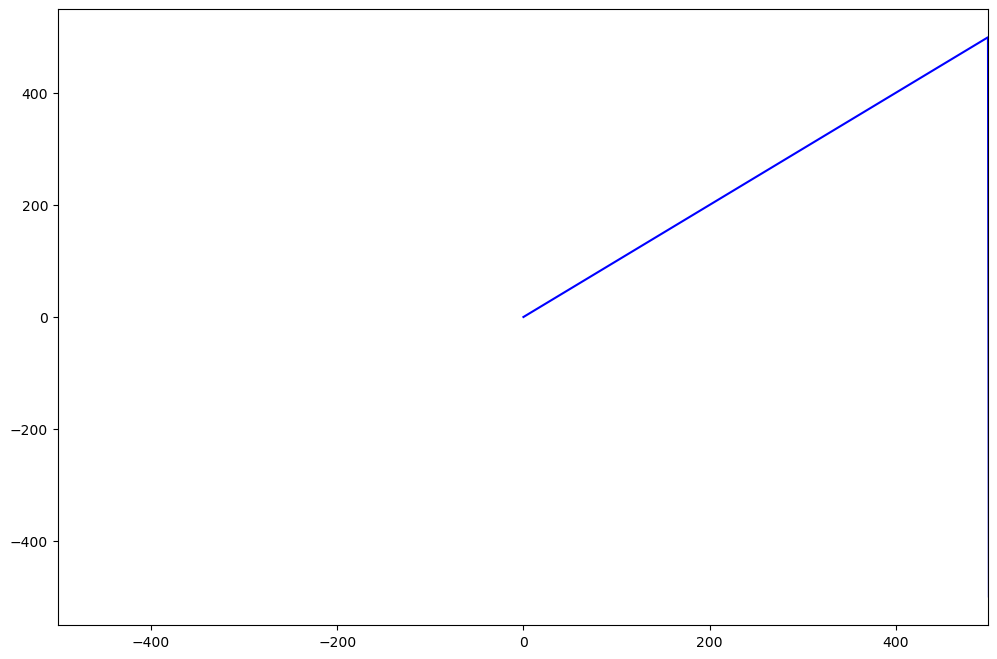

In [29]:
X = sp.fft.fft(x)
nu = sp.fft.fftfreq(N,d=0.001) # FIXME

plt.figure(figsize=(12,8))
plt.plot(nu,'b') # FIXME
plt.xlim(nu.min(),nu.max())
plt.show()

Le spectre qu'on obtient maintenant [est conforme / n'est pas conforme] à la théorie parce que ❓❓❓

### La magie (ou galère, c'est selon) de `fftshift`

Si vous êtes allés lire la documentation de [`sp.fft.fftfreq`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.fftfreq.html) (sinon, faites le maintenant ! 😡), vous avez sans doute remarqué un comportement étrange à première vue : elle renvoie les fréquences discrètes positives dans la première moitié du vecteur, et les fréquences négatives ensuite. 

Cela vient du faire que $X(-\nu) = \overline{X(\nu)}$ pour un signal $x$ à valeurs réelles. Autrement dit, la valeur de la TFD pour les fréquences discrètes négatives se déduit des fréquences positives en prenant le conjugué. On ne peut donc garder que $X[\nu]$ pour $\nu \geq 0$ puisque les valeurs de $X$ pour $\nu < 0$ s'en déduisent immédiatement, permettant ainsi de ne stocker que la moitié des valeurs de la TFD. 

Cependant, lorsque l'on souhaite tracer le spectre $\vert X \vert $ de la TFD d'un signal, on se ramène à un ordre logique $[\nu < 0 \ ; 0 \ ; \nu > 0]$ pour le vecteur de fréquence discrètes. Il conviendra donc d'utiliser [`sp.fft.fftshift`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.fftshift.html) <b>sur le vecteur de fréquences discrètes</b> (pour ramener la fréquence nulle au centre de ce vecteur et non en première position) <b>ainsi que sur la TFD</b> (pour que les valeurs $X[\nu_k]$ coïncident bien avec l'ordre des fréquences discrètes). 

In [31]:
# 🛑 Reproduction de l'exemple donné dans la doc de fftshift
dummy_freqs = sp.fft.fftfreq(10,0.1) # Génère 10 fréquences discrètes avec pas de temps de 0.1
print("Fréquences discrètes sans fftshift :",dummy_freqs)
print("Fréquences discrètes avec fftshift :",sp.fft.fftshift(dummy_freqs))

Fréquences discrètes sans fftshift : [ 0.  1.  2.  3.  4. -5. -4. -3. -2. -1.]
Fréquences discrètes avec fftshift : [-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.]


On fera également attention à bien appliquer l'opération inverse `sp.fft.ifftshift` si on veut inverser une transformée de Fourier (après une opération de filtrage par exemple) sur laquelle `sp.fft.fftshift` avait été appliquée.

### 🛠️ 🚧 👷  À vous de jouer !

Affichez les 10 premières valeurs du vecteur de fréquences discrètes `nu` calculé à la question précédente sans et avec application de `fftshift`, et vérifiez le bon comportement de cette fonction.

<u>Python pro tip :</u> pas besoin de boucle pour afficher les $N$ premières valeurs d'un vecteur $x$, il suffit de faire `x[:N]`

In [38]:
# Affichage des 10 premières valeurs de nu sans fftshift
dummy_freqs = sp.fft.fftfreq(10,0.001)
print("Fréquences discrètes sans fftshift :", dummy_freqs)

Fréquences discrètes sans fftshift : [   0.  100.  200.  300.  400. -500. -400. -300. -200. -100.]


In [39]:
# Affichage des 10 premières valeurs de nu avec fftshift
freq=sp.fft.fftfreq(10,d=0.001)
print("Fréquences discrètes avec fftshift :",sp.fft.fftshift(freq))

Fréquences discrètes avec fftshift : [-500. -400. -300. -200. -100.    0.  100.  200.  300.  400.]


### Normalisation de la TFD

Un petit mot également à propos des coefficients de normalisation pour le calcul de la TFD directe (3) et TFD inverse (4). Le fait que la TFD inverse porte un facteur $\frac{1}{N}$ n'est ni une convention universelle (quoique la plus répandue), ni une obligation. Par contre, le produit des facteurs de normalisation de la TFD directe et TFD inverse doit être égal à $\frac{1}{N}$ : on peut donc normaliser (3) par $\frac{1}{N}$ si on utilise un coefficient $1$ devant la TFD inverse (4), ou utiliser $\frac{1}{\sqrt{N}}$ devant (3) et (4).

Par défaut, c'est la TFD inverse qui porte le $\frac{1}{N}$ dans `scipy` (se reporter à [`scipy.fft.ifft`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.ifft.html#scipy.fft.ifft)), mais on peut évidemment utiliser une autre normalisation à la main (par exemple, en divisant par $N$ le résultat de `scipy.fft.fft` et en multipliant par $N$ celui de `scipy.fft.ifft`).

Dans tous les cas, si `scipy.fft.ifft(scipy.fft.fft(x))` n'est pas égal à `x` à quelques imprécisions numériques près, c'est qu'on a planté quelque chose, quelque part. Vérifions le ici.

In [40]:
# 🛑 Avec la normalisation par défaut de scipy
X = sp.fft.fft(x) # TFD
x_inv = np.real(sp.fft.ifft(X)) # TFD inverse
np.allclose(x,x_inv,atol=1e-5)

True

In [41]:
# 🛑 Avec une normalisation perso
X_norm = sp.fft.fft(x)/N # Division de la TFD par  N
x_norm_inv = np.real(sp.fft.ifft(X_norm)*N) # Multiplication de la TFD inverse par N
np.allclose(x,x_norm_inv,atol=1e-5)

True

# Bravo !
Vous avez enfin pris en main les notions indispensables pour manipuler la TFD ! Mais une minute, ça serait malheureusement trop beau si c'était aussi simple... Allez, courage, il est temps de se frotter aux [vraies galères du traitement numérique du signal](TP2_Fourier_intro_exo2.ipynb) !